In [49]:
import matplotlib.pyplot as plt
import keras
import random
import pandas as pd
import numpy as np
import sklearn.preprocessing
from math import *
import cv2 as cv
from PIL import Image, ImageOps
from IPython.display import display 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

In [50]:
def show_bgrimg(image):#for diplaying bgr images
    plt.figure(figsize=(12, 10), dpi=80)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()
def show_rgbimg(image):#for displaying rgb images
    plt.figure(figsize=(12, 10), dpi=80)
    plt.imshow(image)
    plt.show()
def show_bnw(image):#for displaying grayscale images 
    plt.figure(figsize=(12, 10), dpi=80)
    plt.imshow(image,cmap="gray")
    plt.show()

In [51]:
#function to finc DCT(discrete cosine transform) of an image
def convert_img_to_dct(image):
    imagefloat=image.astype("float")
    dct_img=cv.dct(imagefloat)
    return dct_img

#function to convert Img from DCT
def convert_dct_to_img(dct_img):
    image=cv.idct(dct_img)
    return image
    

In [85]:
#function to convert to ycbcr
def conv_ycbcr(image):
    ycbcr_img=cv.cvtColor(image, cv.COLOR_BGR2YCR_CB)
    return ycbcr_img[:,:,0]


In [53]:
def patch_extraction(image,subw,subh):
    result=[]
    n_x=image.shape[1]//subw
    n_y=image.shape[0]//subh
    for i in range(n_x):
        for j in range(n_y):
            result.append(image[j*subh:(j+1)*subh:1,i*subw:(i+1)*subw:1])
    return result



In [54]:

def generateSubImage (file,hori,ver):
  try: 
    img  = Image.open(file) 
  except IOError:
    pass

  width, height = img.size
  horizontal = width//hori
  vertical = height//ver

  retval = []

  for i in range(0,horizontal):
      for j in range(0,vertical):
        left = hori*i
        top = ver*j
        right = hori*(i+1)
        bottom = ver*(j+1)
        im2 = img.crop((left, top, right, bottom))
        retval.append(im2)
  return retval

In [117]:
#function for bilateral filter and bicubic interpolation
#check=true for rgb images
def preprocessing(image,scale=2):
    image=cv.cvtColor(image, cv.COLOR_BGR2YCR_CB)
    image=image[:,:,0]
    width=image.shape[1]
    height=image.shape[0]
    #gblur_img=cv.GaussianBlur(image,(7,7),0)
    gblur_img=cv.bilateralFilter(image,15,50,50)
    resized_img=cv.resize(gblur_img,(width*scale,height*scale), interpolation=cv.INTER_CUBIC)
    return resized_img

In [56]:
#loading datasets
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiab

In [57]:
ds = tfds.load('div2k', split='train', shuffle_files=True)
print(ds)

<_OptionsDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>


In [58]:
#to show the functions of "ds"
print(dir(ds))

['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_checkpoint_dependencies', '_consumers', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_ref', '_input_dataset', '_inputs', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_map_resources', '_maybe_initialize_trackable', '_name_b

['hr', 'lr']
(1356, 2040, 3) (678, 1020, 3)


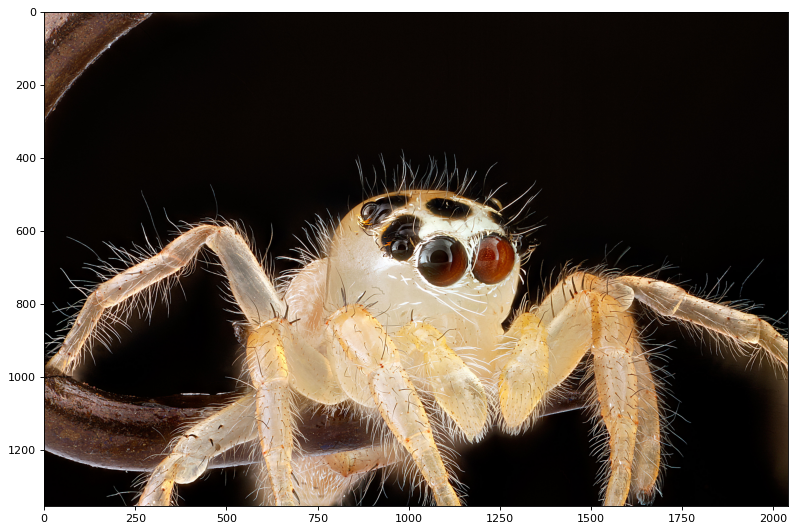

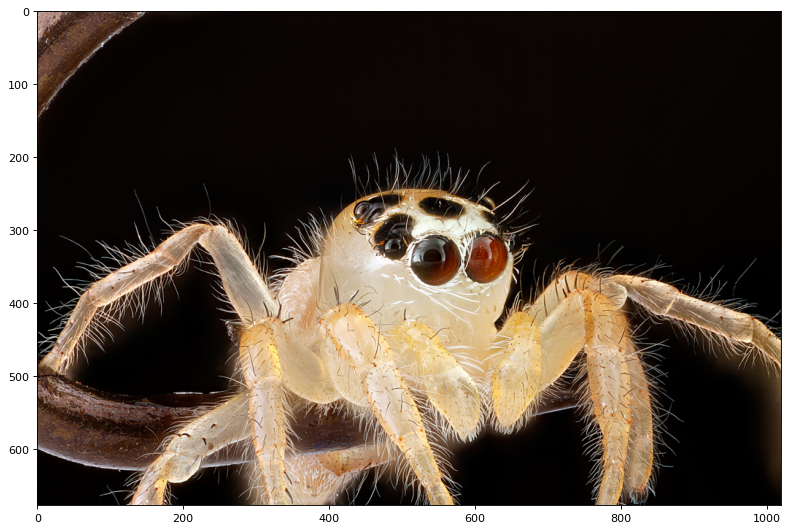

In [59]:
#testing if the dataset has loaded
for example in ds.take(1):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  hr_img = example["hr"]
  lr_img = example["lr"]
  print(hr_img.shape, lr_img.shape)
show_rgbimg(np.array(hr_img))
show_rgbimg(np.array(lr_img))

How to extract data from a tensorflow dataset: https://www.tensorflow.org/datasets/overview

In [73]:
#extracting images from dataset
train_x=[]
train_y=[]
no_of_images=5
i=0
for sample in ds:
    train_x.append(np.array(sample["lr"]))
    train_y.append(np.array(sample["hr"]))
    i+=1
    if(i==no_of_images):
        break

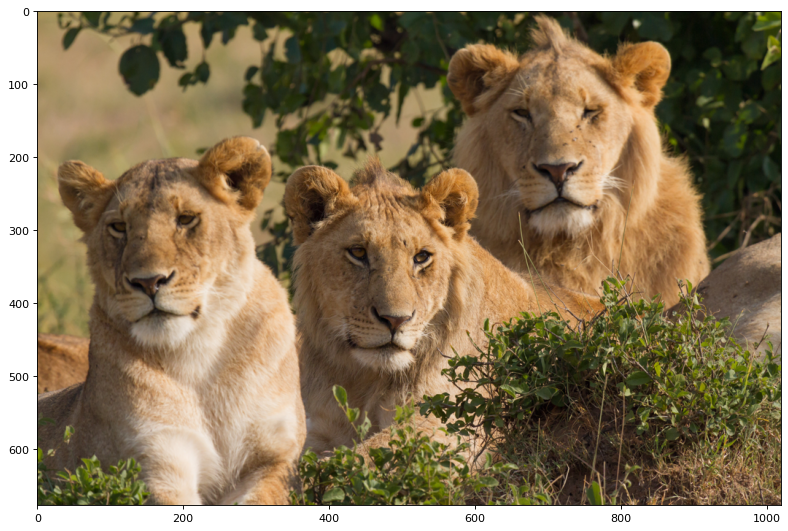

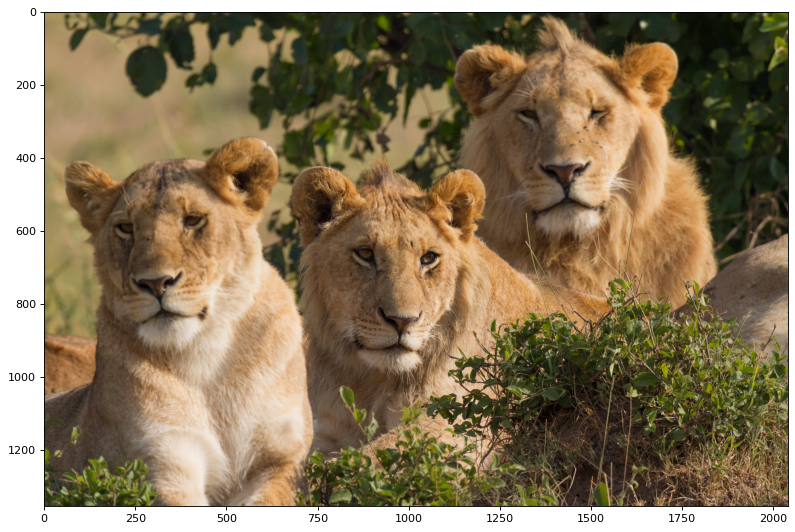

In [74]:
plt.figure(figsize=(12, 10), dpi=80)
plt.imshow(train_x[1])
show_rgbimg(train_y[1])

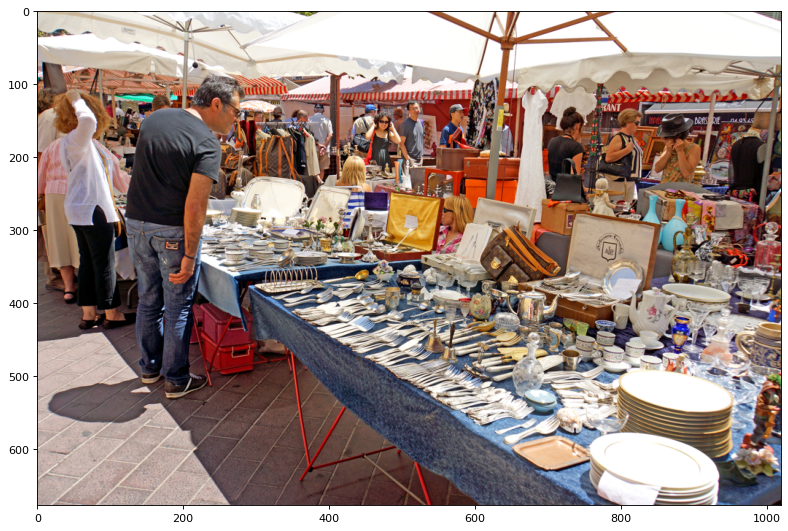

(678, 1020, 3)


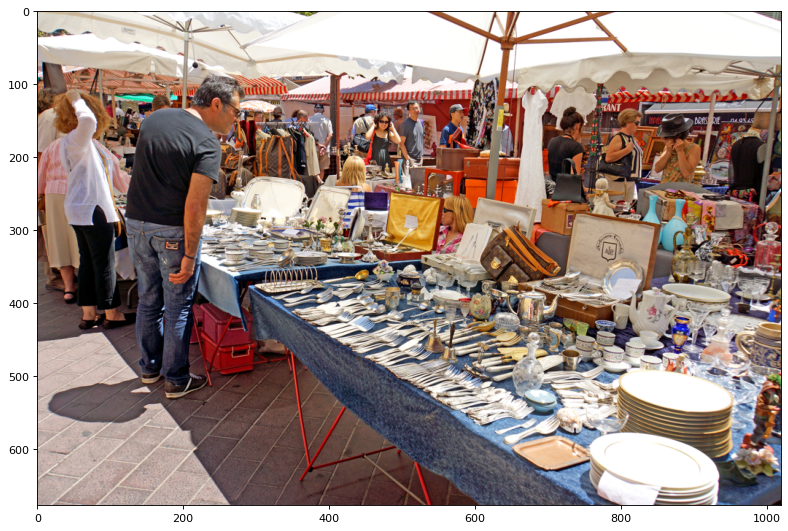

(1356, 2040, 3)


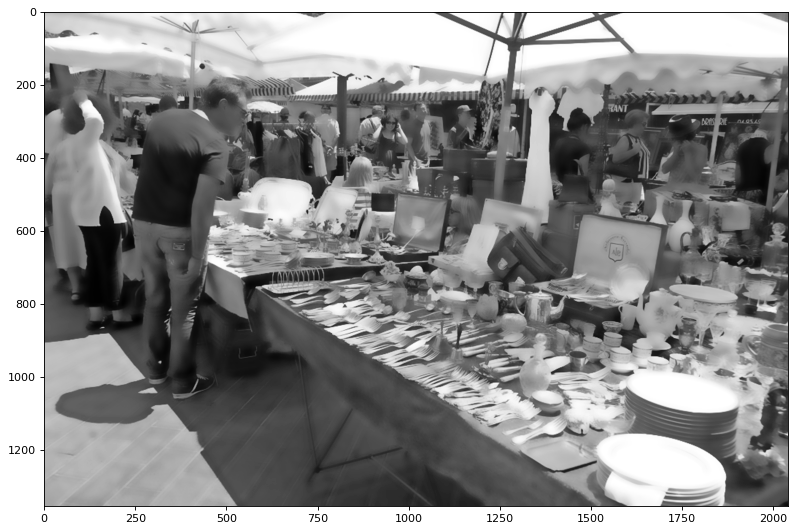

(1356, 2040)


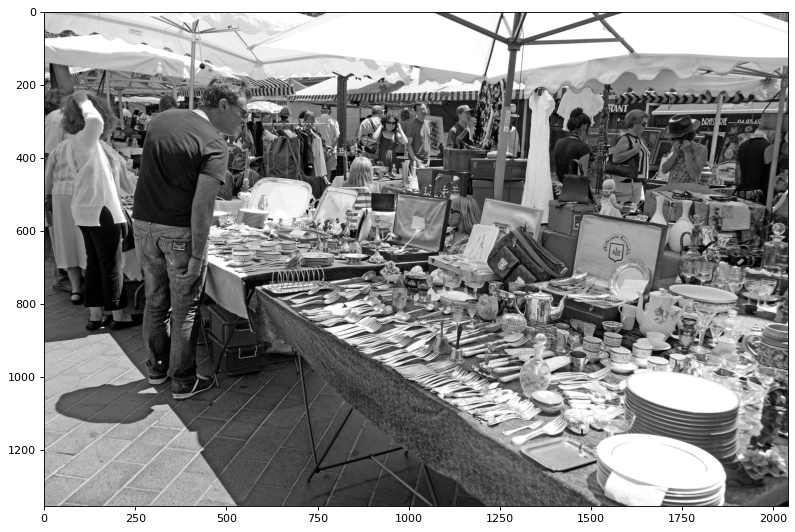

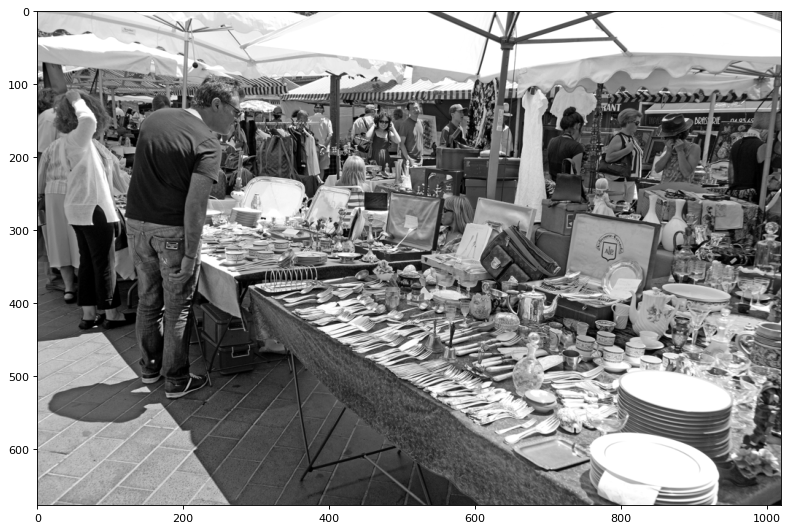

In [87]:
#testig the functions
show_rgbimg(train_x[2])
print(train_x[2].shape)
show_rgbimg(train_x[2])
print(train_y[2].shape)
trial=preprocessing(train_x[2],2)
show_bnw(trial)
print(trial.shape)
ycbcr=conv_ycbcr(train_y[2])
show_bnw(ycbcr)
l=conv_ycbcr(train_x[2])
show_bnw(l)

In [63]:
#shape of the images stored
for i in range(no_of_images):
    print(train_x[i].shape,train_y[i].shape)

(1020, 678, 3) (2040, 1356, 3)
(768, 1020, 3) (1536, 2040, 3)
(678, 1020, 3) (1356, 2040, 3)
(678, 1020, 3) (1356, 2040, 3)
(678, 1020, 3) (1356, 2040, 3)


In [139]:
#initializing parameters
batch_size=50
height=200
width=200

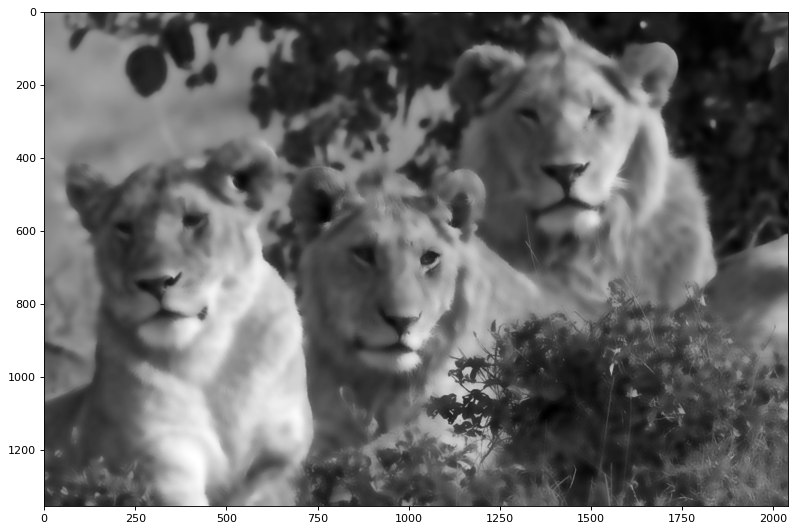

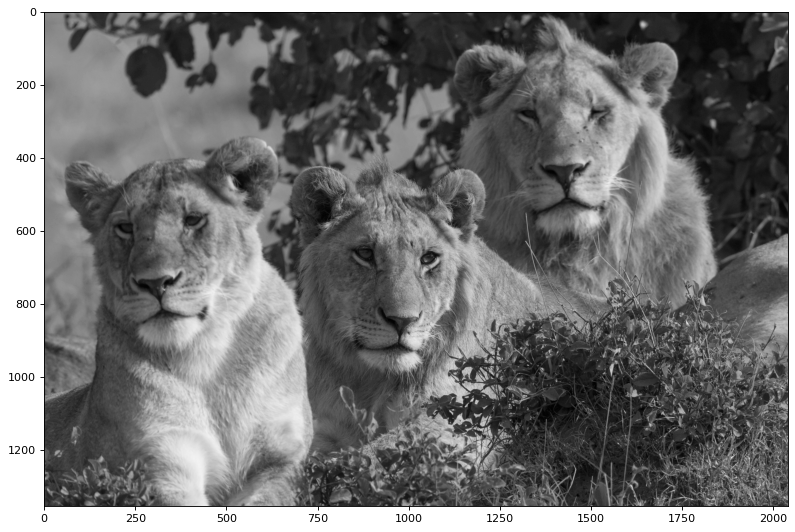

In [140]:
#pre-processing
processed_images_x=list(map(preprocessing,train_x))
grayscale_images_y=list(map(conv_ycbcr,train_y))
show_bnw(processed_images_x[1])
show_bnw(grayscale_images_y[1])

In [141]:
#cropping
cropped_images_x=np.array(patch_extraction(processed_images_x[0],height,width))
cropped_images_y=np.array(patch_extraction(grayscale_images_y[0],height,width))
for element in processed_images_x[1:]:
    cropped_images_x=np.append(cropped_images_x,patch_extraction(element,height,width),axis=0)
for element in grayscale_images_y[1:]:
    cropped_images_y=np.append(cropped_images_y,patch_extraction(element,height,width),axis=0)


310
310


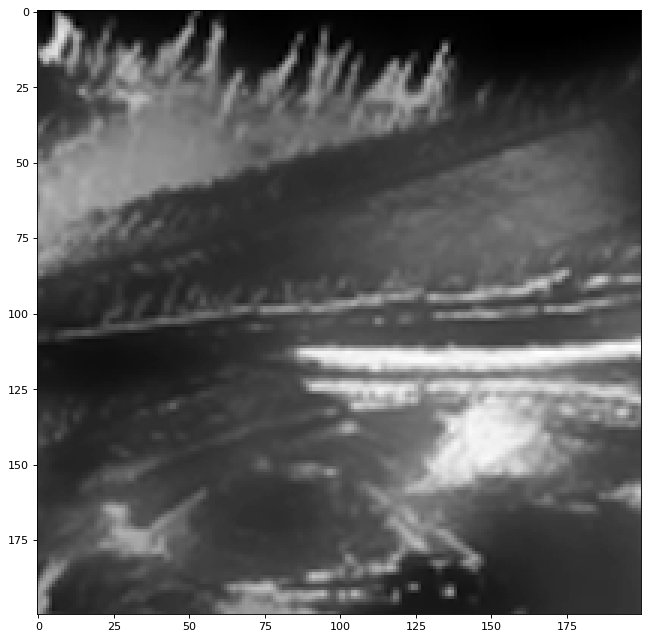

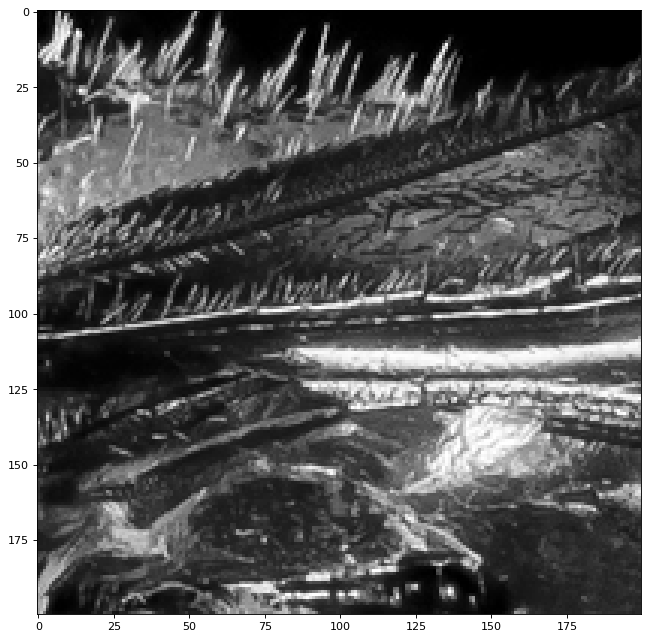

In [151]:
#testing
print(len(cropped_images_x))
print(len(cropped_images_y))

show_bnw(cropped_images_x[30])
show_bnw(cropped_images_y[30])

In [148]:
#network architecture

network=models.Sequential()
network.add(layers.Conv2D(64, (9, 9), activation='relu',input_shape=(height,width,1)))
network.add(layers.Conv2D(32,(1,1),activation='relu'))
network.add(layers.Conv2D(1,(5,5),activation='relu'))

In [149]:
network.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 192, 192, 64)      5248      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 192, 192, 32)      2080      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 188, 188, 1)       801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________
